In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import random

import torch as th
from torch.utils.data import Dataset, Sampler, DataLoader
from transformers import BertTokenizer, BertModel

from sentence_transformers import SentenceTransformer

import numpy as np
import scipy.linalg as linalg

from tqdm.notebook import tqdm
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# import umap
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import seaborn as sns

import faiss

from examples.speech_to_text.data_utils import load_df_from_tsv

In [3]:
root = '/mnt/raid0/siqi/datasets/covost2'
langs = ["fr", "de", "es", "fa", "it", "ru", "pt", "zh-CN", "tr", "ar", "et", "mn", "nl", "sv-SE", "lv", "sl", "ta", "ja", "id"]
os.makedirs('resources', exist_ok=True)
device='cuda'

In [10]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
model = BertModel.from_pretrained("bert-base-cased").to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
model = SentenceTransformer('sentence-transformers/LaBSE').to(device)

In [7]:
batch_size = 2000
for lang in langs:
    df = load_df_from_tsv(os.path.join(root, lang, 'train_st_{}_en.tsv'.format(lang)))
    tgt_texts = df['tgt_text'].tolist()
    with th.inference_mode():
        features = []
        for i in tqdm(range(0, len(tgt_texts), batch_size), desc=lang):
            # inputs = tokenizer(text, return_tensors="pt").to('cuda')
            # outputs = model(**inputs)
            # features.append(outputs.last_hidden_state.cpu())
            outputs = model.encode(tgt_texts[i:i+batch_size])
            features.append(outputs)
        features = np.concatenate(features, axis=0)
        np.save('resources/train_{}.npy'.format(lang), features)

fr:   0%|          | 0/104 [00:00<?, ?it/s]

de:   0%|          | 0/64 [00:00<?, ?it/s]

es:   0%|          | 0/40 [00:00<?, ?it/s]

fa:   0%|          | 0/27 [00:00<?, ?it/s]

it:   0%|          | 0/16 [00:00<?, ?it/s]

ru:   0%|          | 0/7 [00:00<?, ?it/s]

pt:   0%|          | 0/5 [00:00<?, ?it/s]

zh-CN:   0%|          | 0/4 [00:00<?, ?it/s]

tr:   0%|          | 0/2 [00:00<?, ?it/s]

ar:   0%|          | 0/2 [00:00<?, ?it/s]

et:   0%|          | 0/1 [00:00<?, ?it/s]

mn:   0%|          | 0/2 [00:00<?, ?it/s]

nl:   0%|          | 0/4 [00:00<?, ?it/s]

sv-SE:   0%|          | 0/2 [00:00<?, ?it/s]

lv:   0%|          | 0/2 [00:00<?, ?it/s]

sl:   0%|          | 0/1 [00:00<?, ?it/s]

ta:   0%|          | 0/1 [00:00<?, ?it/s]

ja:   0%|          | 0/1 [00:00<?, ?it/s]

id:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
means = []
covs = []
for i in tqdm(range(len(langs))):
    features = np.load('resources/{}.npy'.format(langs[i]))
    mean = features.mean(axis=0)
    cov = np.cov(features, rowvar=False)
    means.append(mean)
    covs.append(cov)

  0%|          | 0/19 [00:00<?, ?it/s]

In [14]:
matrix = np.zeros((len(langs), len(langs)))
for i in range(len(langs)):
    for j in tqdm(range(len(langs)), desc=langs[i]):
        if j > i:
            A = ((means[i] - means[j]) ** 2).sum()
            B = np.trace(covs[i] + covs[j] - 2 * linalg.sqrtm(np.matmul(covs[i], covs[j])))
            matrix[i, j] = (A + B) ** 0.5
        elif j == i:
            matrix[i, i] = 0.
        else:
            matrix[i, j] = matrix[j, i]

fr:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/ipykernel_22757/2123211394.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  matrix[i, j] = (A + B) ** 0.5


de:   0%|          | 0/19 [00:00<?, ?it/s]

es:   0%|          | 0/19 [00:00<?, ?it/s]

fa:   0%|          | 0/19 [00:00<?, ?it/s]

it:   0%|          | 0/19 [00:00<?, ?it/s]

ru:   0%|          | 0/19 [00:00<?, ?it/s]

pt:   0%|          | 0/19 [00:00<?, ?it/s]

zh-CN:   0%|          | 0/19 [00:00<?, ?it/s]

tr:   0%|          | 0/19 [00:00<?, ?it/s]

ar:   0%|          | 0/19 [00:00<?, ?it/s]

et:   0%|          | 0/19 [00:00<?, ?it/s]

mn:   0%|          | 0/19 [00:00<?, ?it/s]

nl:   0%|          | 0/19 [00:00<?, ?it/s]

sv-SE:   0%|          | 0/19 [00:00<?, ?it/s]

lv:   0%|          | 0/19 [00:00<?, ?it/s]

sl:   0%|          | 0/19 [00:00<?, ?it/s]

ta:   0%|          | 0/19 [00:00<?, ?it/s]

ja:   0%|          | 0/19 [00:00<?, ?it/s]

id:   0%|          | 0/19 [00:00<?, ?it/s]

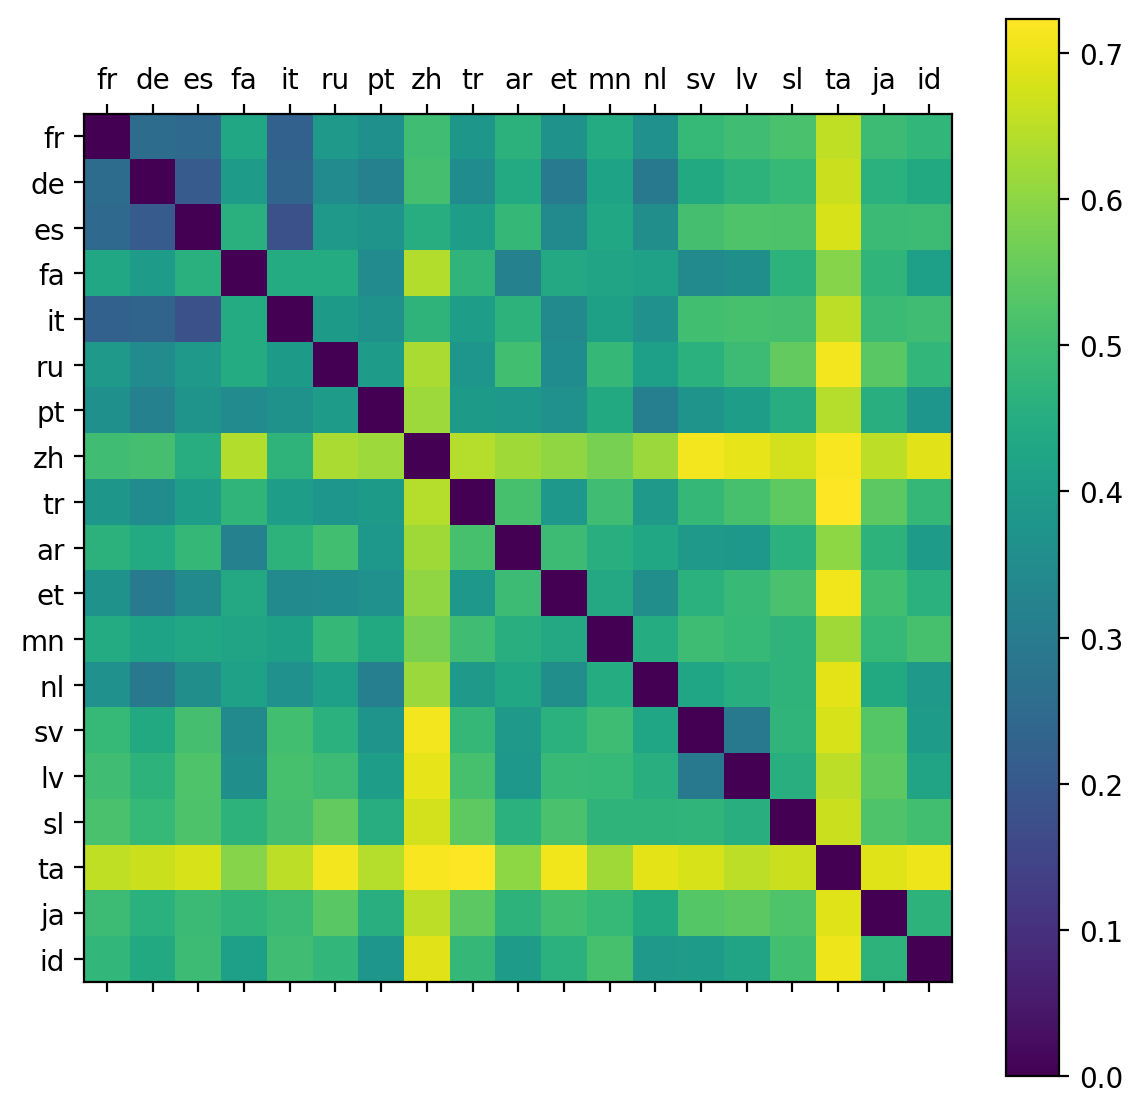

In [19]:
fig = plt.figure(dpi=200, figsize=(7, 7))
ax = fig.add_subplot(111)
cax = ax.matshow(matrix) #, norm=mp.colors.Normalize(0, 7))
fig.colorbar(cax)
ax.set_xticks(range(len(langs)))
ax.set_yticks(range(len(langs)))
ax.set_xticklabels([lang[:2] for lang in langs])
ax.set_yticklabels([lang[:2] for lang in langs])
plt.savefig('frechet_dist.png')

In [4]:
all_features = []
n_labels = []
for i in tqdm(range(len(langs))):
    features = np.load('resources/train_{}.npy'.format(langs[i]))
    n_labels.append(features.shape[0])
    all_features.append(features)
all_features = np.concatenate(all_features, axis=0)

  0%|          | 0/19 [00:00<?, ?it/s]

In [5]:
# projector = Isomap(n_neighbors=20, n_components=2, n_jobs=32)

# projector = MDS(n_components=2, metric='True', verbose=1, n_jobs=32)

# sc = StandardScaler()
# pca = PCA(n_components=64)
# tsne = TSNE(n_components=2, perplexity=60, init='random', verbose=2, learning_rate='auto')
# projector = Pipeline([
#     ('std_scaler', sc),
#     ('pca', pca),
#     ('tsne', tsne)
# ])

# projector = umap.UMAP(n_neighbors=50, n_components=2, metric='cosine', init='spectral', min_dist=0.01, local_connectivity=5, negative_sample_rate=10, verbose=True)

projector = TSNE(n_components=2, perplexity=60, init='pca', verbose=2, learning_rate='auto')

dots = projector.fit_transform(all_features)

[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 81360 samples in 0.037s...
[t-SNE] Computed neighbors for 81360 samples in 151.541s...
[t-SNE] Computed conditional probabilities for sample 1000 / 81360
[t-SNE] Computed conditional probabilities for sample 2000 / 81360
[t-SNE] Computed conditional probabilities for sample 3000 / 81360
[t-SNE] Computed conditional probabilities for sample 4000 / 81360
[t-SNE] Computed conditional probabilities for sample 5000 / 81360
[t-SNE] Computed conditional probabilities for sample 6000 / 81360
[t-SNE] Computed conditional probabilities for sample 7000 / 81360
[t-SNE] Computed conditional probabilities for sample 8000 / 81360
[t-SNE] Computed conditional probabilities for sample 9000 / 81360
[t-SNE] Computed conditional probabilities for sample 10000 / 81360
[t-SNE] Computed conditional probabilities for sample 11000 / 81360
[t-SNE] Computed conditional probabilities for sample 12000 / 81360
[t-SNE] Computed conditional probabilities for 

/mnt/nvme/siqi/anaconda3/envs/st/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 113.3805466, gradient norm = 0.0000814 (50 iterations in 12.280s)
[t-SNE] Iteration 100: error = 113.3839493, gradient norm = 0.0000298 (50 iterations in 12.060s)
[t-SNE] Iteration 150: error = 113.3793793, gradient norm = 0.0000128 (50 iterations in 11.909s)
[t-SNE] Iteration 200: error = 113.3778610, gradient norm = 0.0000037 (50 iterations in 12.326s)
[t-SNE] Iteration 250: error = 113.3775635, gradient norm = 0.0000022 (50 iterations in 11.721s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 113.377563
[t-SNE] Iteration 300: error = 5.4216261, gradient norm = 0.0004204 (50 iterations in 11.353s)
[t-SNE] Iteration 350: error = 5.0718112, gradient norm = 0.0001827 (50 iterations in 10.973s)
[t-SNE] Iteration 400: error = 4.9015880, gradient norm = 0.0001107 (50 iterations in 11.007s)
[t-SNE] Iteration 450: error = 4.7950826, gradient norm = 0.0000777 (50 iterations in 10.990s)
[t-SNE] Iteration 500: error = 4.7198882, gradient norm =

In [ ]:
cnt = 0
fig, axs = plt.subplots(4, 5, dpi=200, figsize=(10, 8))
for idx, lang in enumerate(langs):
    ax = axs[idx // 5, idx % 5]
    ax.scatter(*zip(*dots[cnt:cnt + n_labels[idx]]), label=lang, s=0.5)
    ax.set_title(lang)
    ax.set_xticks([])
    ax.set_yticks([])
    cnt += n_labels[idx]
for idx in range(len(langs), 20):
    ax = axs[idx // 5, idx % 5]
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('tsne.png')

NameError: name 'plt' is not defined

In [72]:
df = pd.DataFrame(columns=['x', 'y', 'lang'])
cnt = 0
xs = []
ys = []
ls = []
for idx in range(3):
    xs.extend(dots[cnt:cnt+n_labels[idx], 0].tolist())
    ys.extend(dots[cnt:cnt+n_labels[idx], 1].tolist())
    ls.extend([langs[idx]] * n_labels[idx])
    cnt += n_labels[idx]
df['x'] = xs
df['y'] = ys
df['lang'] = ls

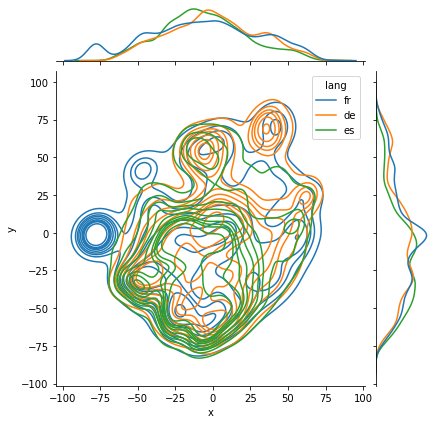

In [73]:
sns.jointplot(data=df, x='x', y='y', hue='lang', kind='kde')

# Extract cross-lingual sentences with similar projected embeddings

In [5]:
tgt_texts_per_lang = []
audio_per_lang = []
for lang in langs:
    df = load_df_from_tsv(os.path.join(root, lang, 'train_st_{}_en.tsv'.format(lang)))
    tgt_texts = df['tgt_text'].tolist()
    tgt_texts_per_lang.append(tgt_texts)
    audio_per_lang.append(df['audio'].tolist())

  0%|          | 0/1 [00:00<?, ?it/s]

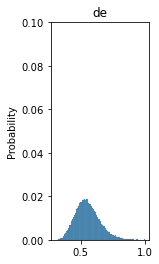

In [7]:
low_lang = 'fr'
low_idx = langs.index(low_lang)

# plt.figure(figsize=(3 * 5, 5), dpi=600)
for _, lang in enumerate(tqdm(['de'])):
    high_lang = lang
    high_idx = langs.index(lang)

    high_start = sum(n_labels[:high_idx])
    high_end = sum(n_labels[:high_idx + 1])

    low_start = sum(n_labels[:low_idx])
    low_end = sum(n_labels[:low_idx + 1])

    tgt_texts_high = tgt_texts_per_lang[high_idx]
    tgt_texts_low = tgt_texts_per_lang[low_idx]

    audio_high = audio_per_lang[high_idx]
    audio_low = audio_per_lang[low_idx]

    d = all_features.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(all_features[high_start : high_end])
    max_sims, max_ids = index.search(all_features[low_start : low_end], 1)
    max_sims = max_sims.reshape(-1)
    max_ids = max_ids.reshape(-1)

    # perm = list(range(len(max_ids)))
    # random.shuffle(perm)
    # n_sample = 100
    # columns = ['sentence in low-resource language', 'audio', 'most similar sentence in high-resource language', 'audio', 'Similarity (0-1)']
    # df = pd.DataFrame(columns=columns)
    # for idx in perm[:n_sample]:
    #     new_df = pd.DataFrame([[tgt_texts_low[idx], '<audio controls=""><source src="audio/{}" type="audio/wav"></audio>'.format(audio_low[idx]), \
    #         tgt_texts_high[max_ids[idx]], '<audio controls=""><source src="audio/{}" type="audio/wav"></audio>'.format(audio_high[max_ids[idx]]), \
    #         max_sims[idx]]], columns=columns)
    #     os.system('cp {} {}'.format(os.path.join(root, low_lang, '16kHz', audio_low[idx]), 'audio/'))
    #     os.system('cp {} {}'.format(os.path.join(root, high_lang, '16kHz', audio_high[max_ids[idx]]), 'audio/'))
    #     df = pd.concat([df, new_df], ignore_index=True)
    # df.sort_values(columns[-1], ascending=False).to_html(
    #     'htmls/{}_{}.html'.format(low_lang, high_lang),
    #     index=False,
    #     justify='left',
    #     escape=False,
    # )
    plt.subplot(1, 3, _ + 1)
    if lang != low_lang:
        sns.histplot(max_sims, stat='probability', binrange=(0.3, 1))
        plt.ylim(0, 0.1)
    else:
        plt.hist(max_sims)
    plt.title(lang)
plt.show()

<AxesSubplot:ylabel='Probability'>

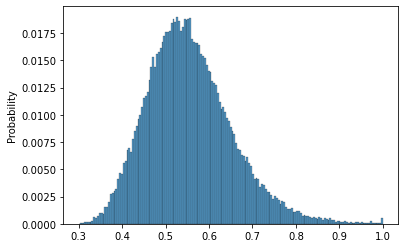

In [8]:
sns.histplot(max_sims, stat='probability', binrange=(0.3, 1))

# Exact Search 

In [6]:
all_features = []
n_labels = []
for i in tqdm(range(len(langs))):
    features = np.load('resources/{}.npy'.format(langs[i]))
    n_labels.append(features.shape[0])
    all_features.append(features)

  0%|          | 0/19 [00:00<?, ?it/s]

In [25]:
d = all_features[0][0].shape[0]
index = faiss.IndexFlatIP(d)
index.add(all_features[0])

In [26]:
D, I = index.search(all_features[1], 5)

In [35]:
exact_matrix = np.zeros((len(langs), len(langs)))
d = all_features[0][0].shape[0]
for i in range(len(langs)):
    index = faiss.IndexFlatIP(d)
    index.add(all_features[i])
    for j in tqdm(range(len(langs)), desc=langs[i]):
        D, I = index.search(all_features[j], 1)
        exact_matrix[i, j] = D.mean()

fr:   0%|          | 0/19 [00:00<?, ?it/s]

de:   0%|          | 0/19 [00:00<?, ?it/s]

es:   0%|          | 0/19 [00:00<?, ?it/s]

fa:   0%|          | 0/19 [00:00<?, ?it/s]

it:   0%|          | 0/19 [00:00<?, ?it/s]

ru:   0%|          | 0/19 [00:00<?, ?it/s]

pt:   0%|          | 0/19 [00:00<?, ?it/s]

zh-CN:   0%|          | 0/19 [00:00<?, ?it/s]

tr:   0%|          | 0/19 [00:00<?, ?it/s]

ar:   0%|          | 0/19 [00:00<?, ?it/s]

et:   0%|          | 0/19 [00:00<?, ?it/s]

mn:   0%|          | 0/19 [00:00<?, ?it/s]

nl:   0%|          | 0/19 [00:00<?, ?it/s]

sv-SE:   0%|          | 0/19 [00:00<?, ?it/s]

lv:   0%|          | 0/19 [00:00<?, ?it/s]

sl:   0%|          | 0/19 [00:00<?, ?it/s]

ta:   0%|          | 0/19 [00:00<?, ?it/s]

ja:   0%|          | 0/19 [00:00<?, ?it/s]

id:   0%|          | 0/19 [00:00<?, ?it/s]

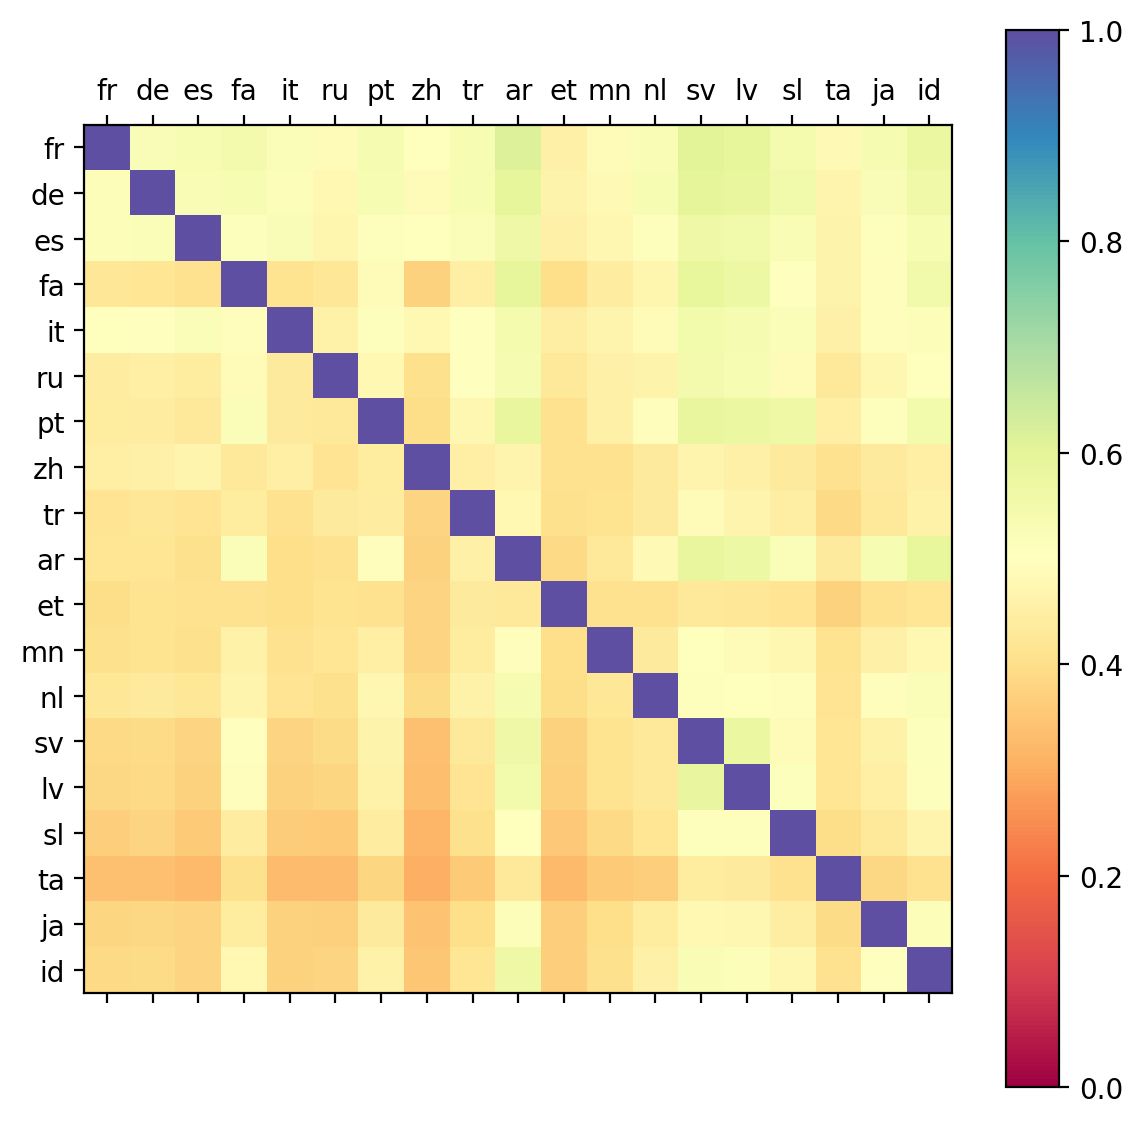

In [47]:
fig = plt.figure(dpi=200, figsize=(7, 7))
ax = fig.add_subplot(111)
cax = ax.matshow(exact_matrix, cmap='Spectral') #, norm=mp.colors.Normalize(0, 7))
cbar = fig.colorbar(cax)
cax.set_clim(0, 1)
ax.set_xticks(range(len(langs)))
ax.set_yticks(range(len(langs)))
ax.set_xticklabels([lang[:2] for lang in langs])
ax.set_yticklabels([lang[:2] for lang in langs])
plt.savefig('exact_similarity.png')

In [4]:
class MyDataset(Dataset):
    def __init__(self, langs):
        self.langs = langs
        self.data = []
        self.labels = []
        for lang_id, lang in enumerate(langs):
            for batch_idx in tqdm(os.listdir('/mnt/raid0/siqi/analysis/resources-adv/{}'.format(lang)), desc='Lang {}'.format(lang)):
                x = th.load('/mnt/raid0/siqi/analysis/resources-adv/{}/{}'.format(lang, batch_idx), map_location='cpu')
                self.data.extend(x)
                self.labels.extend([lang_id] * len(x))

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    def __len__(self):
        return len(self.data)
    
    def collate(self, indices):
        inputs = []
        labels = []

        batch = [self[idx] for idx in indices]
        max_len = max(data.size(0) for data, _ in batch)
        padding_mask = th.zeros(len(batch), max_len).bool()
        for i, (data, label) in enumerate(batch):
            if data.size(0) < max_len:
                padding_mask[i, -(max_len - data.size(0)):] = True
                zeros = th.zeros(max_len - data.size(0), data.size(-1))
                inputs.append(th.cat([data, zeros], dim=0).unsqueeze(1))
            else:
                inputs.append(data.unsqueeze(1))
            labels.append(label)

        inputs = th.cat(inputs, dim=1)
        labels = th.LongTensor(labels)

        return inputs.to(device), padding_mask.to(device), labels.to(device)


In [107]:
dataset = MyDataset(langs)

Lang fr:   0%|          | 0/867 [00:00<?, ?it/s]

Lang de:   0%|          | 0/812 [00:00<?, ?it/s]

Lang es:   0%|          | 0/866 [00:00<?, ?it/s]

Lang fa:   0%|          | 0/186 [00:00<?, ?it/s]

Lang it:   0%|          | 0/590 [00:00<?, ?it/s]

Lang ru:   0%|          | 0/406 [00:00<?, ?it/s]

Lang pt:   0%|          | 0/188 [00:00<?, ?it/s]

Lang zh-CN:   0%|          | 0/323 [00:00<?, ?it/s]

Lang tr:   0%|          | 0/70 [00:00<?, ?it/s]

Lang ar:   0%|          | 0/62 [00:00<?, ?it/s]

Lang et:   0%|          | 0/113 [00:00<?, ?it/s]

Lang mn:   0%|          | 0/106 [00:00<?, ?it/s]

Lang nl:   0%|          | 0/71 [00:00<?, ?it/s]

Lang sv-SE:   0%|          | 0/52 [00:00<?, ?it/s]

Lang lv:   0%|          | 0/57 [00:00<?, ?it/s]

Lang sl:   0%|          | 0/13 [00:00<?, ?it/s]

Lang ta:   0%|          | 0/36 [00:00<?, ?it/s]

Lang ja:   0%|          | 0/31 [00:00<?, ?it/s]

Lang id:   0%|          | 0/32 [00:00<?, ?it/s]

In [108]:
th.save(dataset, '/mnt/raid0/siqi/analysis/adv_semantic_dataset.pt')

In [7]:
dataset = th.load('/mnt/raid0/siqi/analysis/ref_audio_dataset.pt')
all_features = [[] for _ in range(len(langs))]
for x, lang_id in dataset:
    x = x.numpy()
    x /= np.linalg.norm(x)
    all_features[lang_id].append(x)
all_features = [np.stack(ft) for ft in all_features]

In [122]:
exact_audio_matrix = np.zeros((len(langs), len(langs)))
d = all_features[0][0].shape[0]
for i in range(len(langs)):
    index = faiss.IndexFlatIP(d)
    index.add(np.stack(all_features[i]))
    for j in tqdm(range(len(langs)), desc=langs[i]):
        D, I = index.search(np.stack(all_features[j]), 1)
        exact_audio_matrix[i, j] = D.mean()

fr:   0%|          | 0/19 [00:00<?, ?it/s]

de:   0%|          | 0/19 [00:00<?, ?it/s]

es:   0%|          | 0/19 [00:00<?, ?it/s]

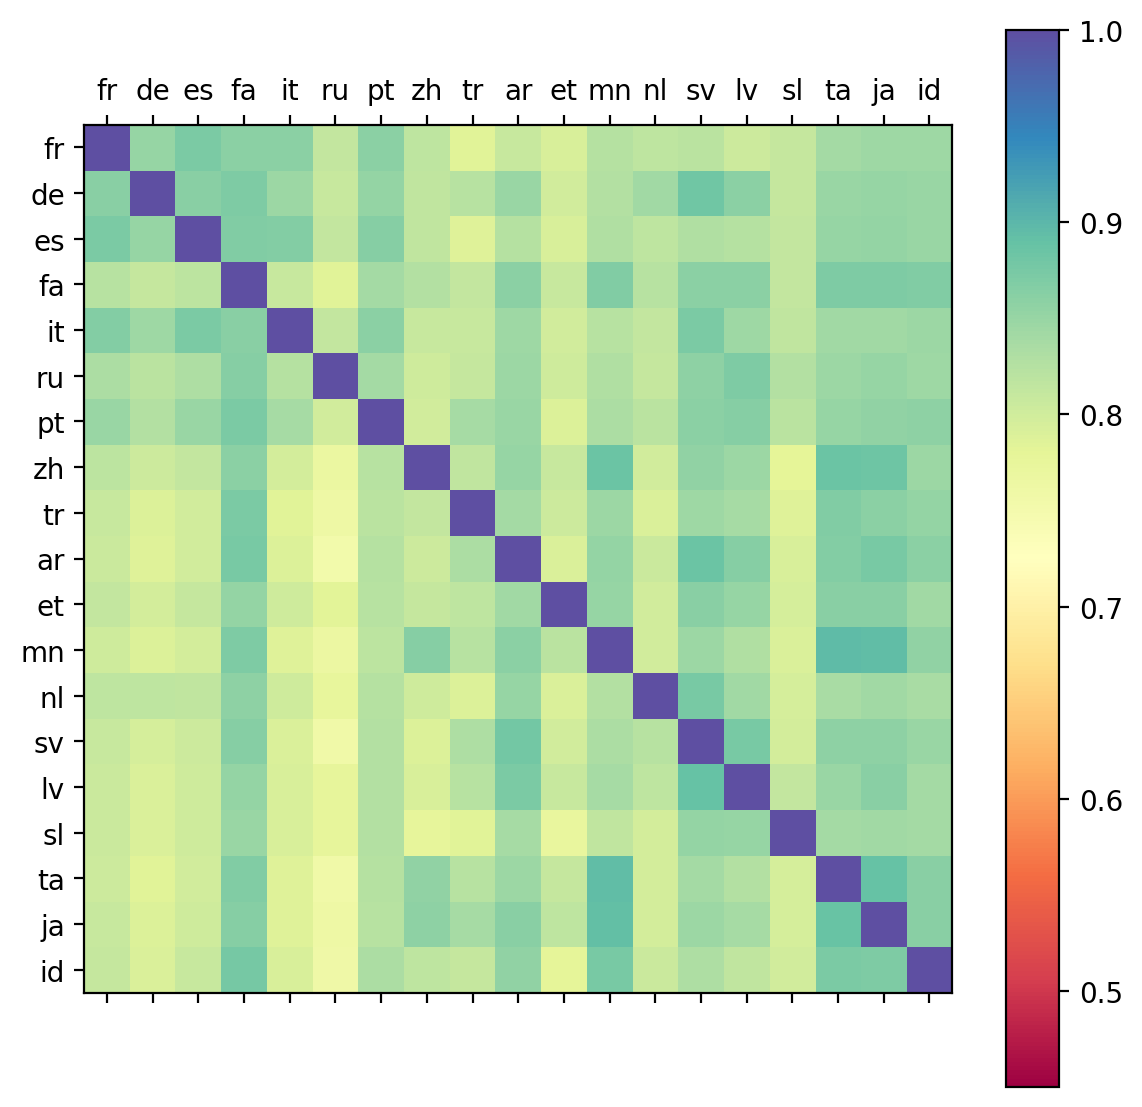

In [ ]:
fig = plt.figure(dpi=200, figsize=(7, 7))
ax = fig.add_subplot(111)
cax = ax.matshow(exact_audio_matrix, cmap='Spectral') #, norm=mp.colors.Normalize(0, 7))
cbar = fig.colorbar(cax)
cax.set_clim(0.75, 1)
ax.set_xticks(range(len(langs)))
ax.set_yticks(range(len(langs)))
ax.set_xticklabels([lang[:2] for lang in langs])
ax.set_yticklabels([lang[:2] for lang in langs])
plt.savefig('adv_exact_audio_similarity.png')

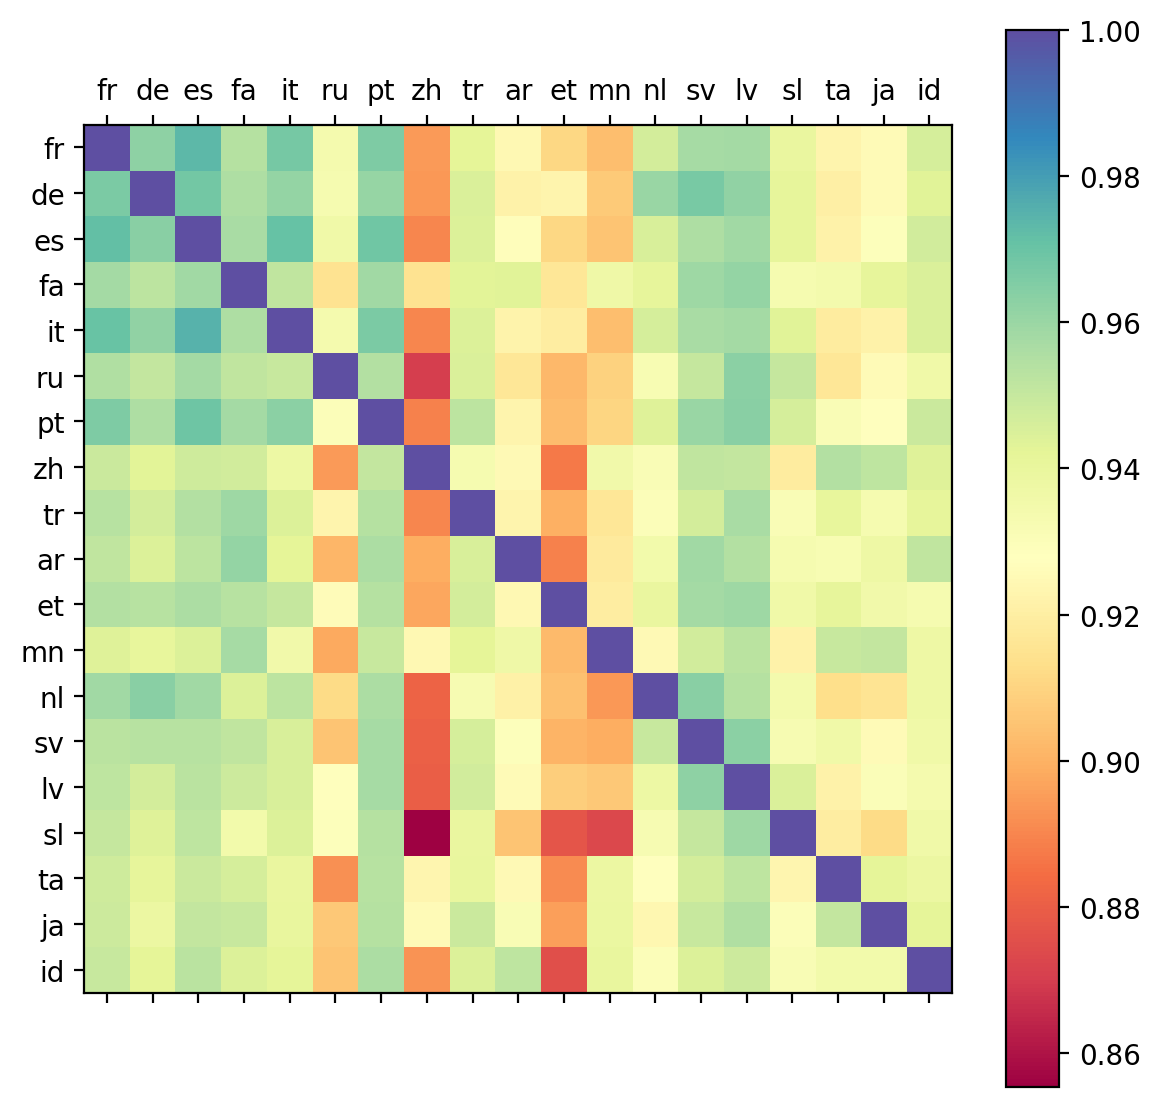

In [76]:
fig = plt.figure(dpi=200, figsize=(7, 7))
ax = fig.add_subplot(111)
cax = ax.matshow(exact_audio_matrix, cmap='Spectral') #, norm=mp.colors.Normalize(0, 7))
cbar = fig.colorbar(cax)
# cax.set_clim(0, 1)
ax.set_xticks(range(len(langs)))
ax.set_yticks(range(len(langs)))
ax.set_xticklabels([lang[:2] for lang in langs])
ax.set_yticklabels([lang[:2] for lang in langs])
plt.savefig('adv_exact_audio_similarity.png')

In [112]:
std_matrix = exact_audio_matrix

In [116]:
adv_matrix = exact_audio_matrix

In [117]:
delta_matrix = adv_matrix - std_matrix

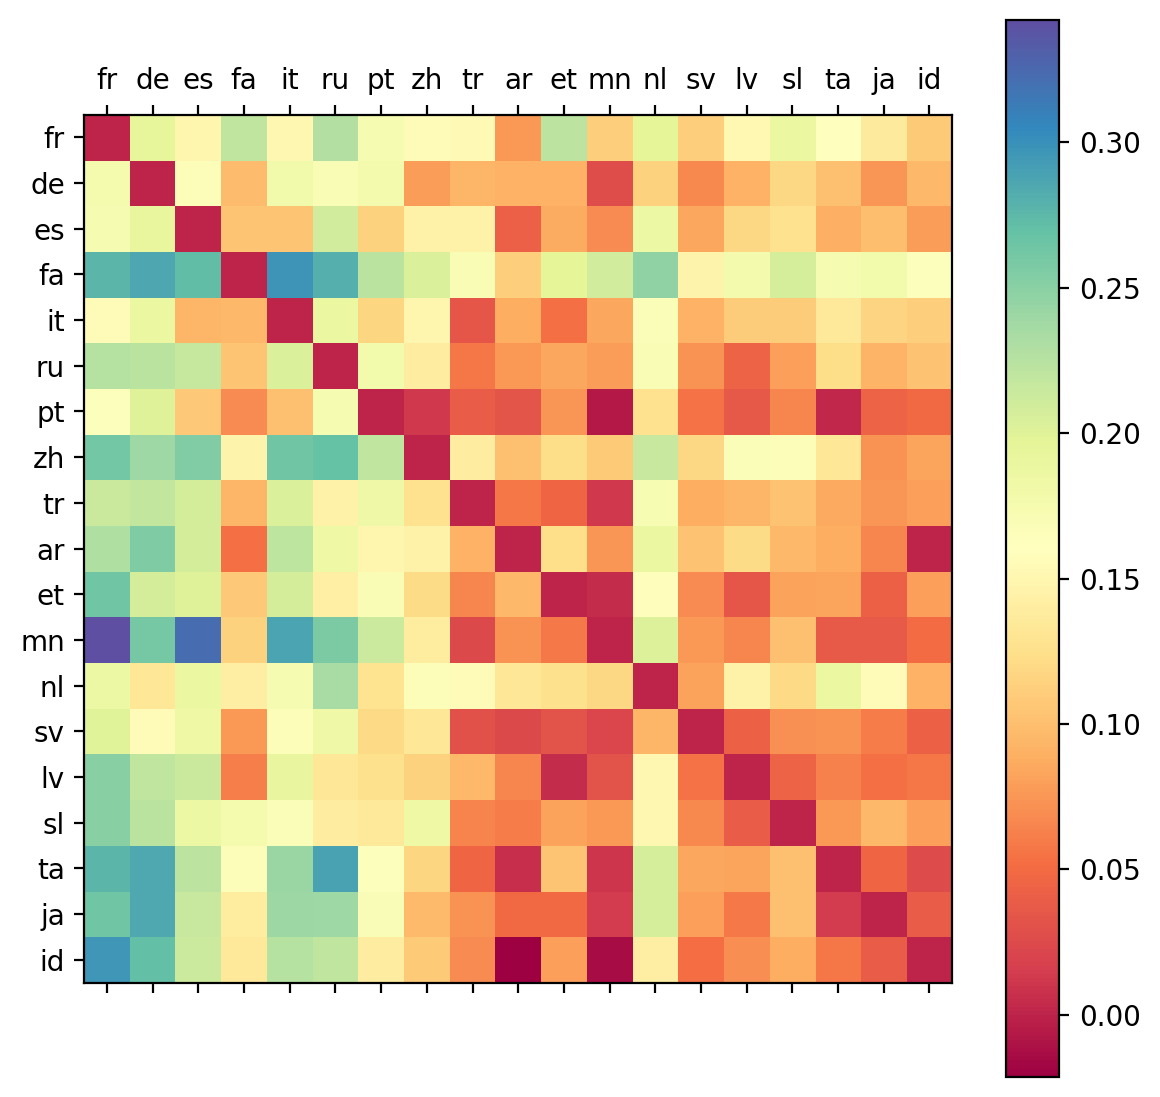

In [118]:
fig = plt.figure(dpi=200, figsize=(7, 7))
ax = fig.add_subplot(111)
cax = ax.matshow(delta_matrix, cmap='Spectral') #, norm=mp.colors.Normalize(0, 7))
cbar = fig.colorbar(cax)
# cax.set_clim(0, 1)
ax.set_xticks(range(len(langs)))
ax.set_yticks(range(len(langs)))
ax.set_xticklabels([lang[:2] for lang in langs])
ax.set_yticklabels([lang[:2] for lang in langs])
plt.savefig('delta_exact_audio_similarity.png')

In [ ]:
dataset = th.load('/mnt/raid0/siqi/analysis/adv_dataset.pt')

In [94]:
all_features = [[] for _ in range(len(langs))]
for seq_feature, lang_id in tqdm(dataset):
    x = seq_feature.mean(dim=0).cpu().numpy()
    x /= np.linalg.norm(x)
    all_features[lang_id].append(x)

  0%|          | 0/64060 [00:00<?, ?it/s]

In [95]:
adv_exact_matrix = np.zeros((len(langs), len(langs)))
d = all_features[0][0].shape[0]
for i in range(len(langs)):
    index = faiss.IndexFlatIP(d)
    index.add(np.stack(all_features[i]))
    for j in tqdm(range(len(langs)), desc=langs[i]):
        D, I = index.search(np.stack(all_features[j]), 1)
        adv_exact_matrix[i, j] = D.mean()

fr:   0%|          | 0/19 [00:00<?, ?it/s]

ValueError: need at least one array to stack

# PCA

In [61]:
all_features = []
n_utt = []
for lang in langs:
    features = np.load('resources/{}.npy'.format(lang))
    all_features.append(features)
    n_utt.append(features.shape[0])
all_features = np.concatenate(all_features)

In [62]:
pca_solver = PCA(n_components=64)
projected_features = pca_solver.fit_transform(all_features)

TypeError: scatter() got multiple values for argument 's'

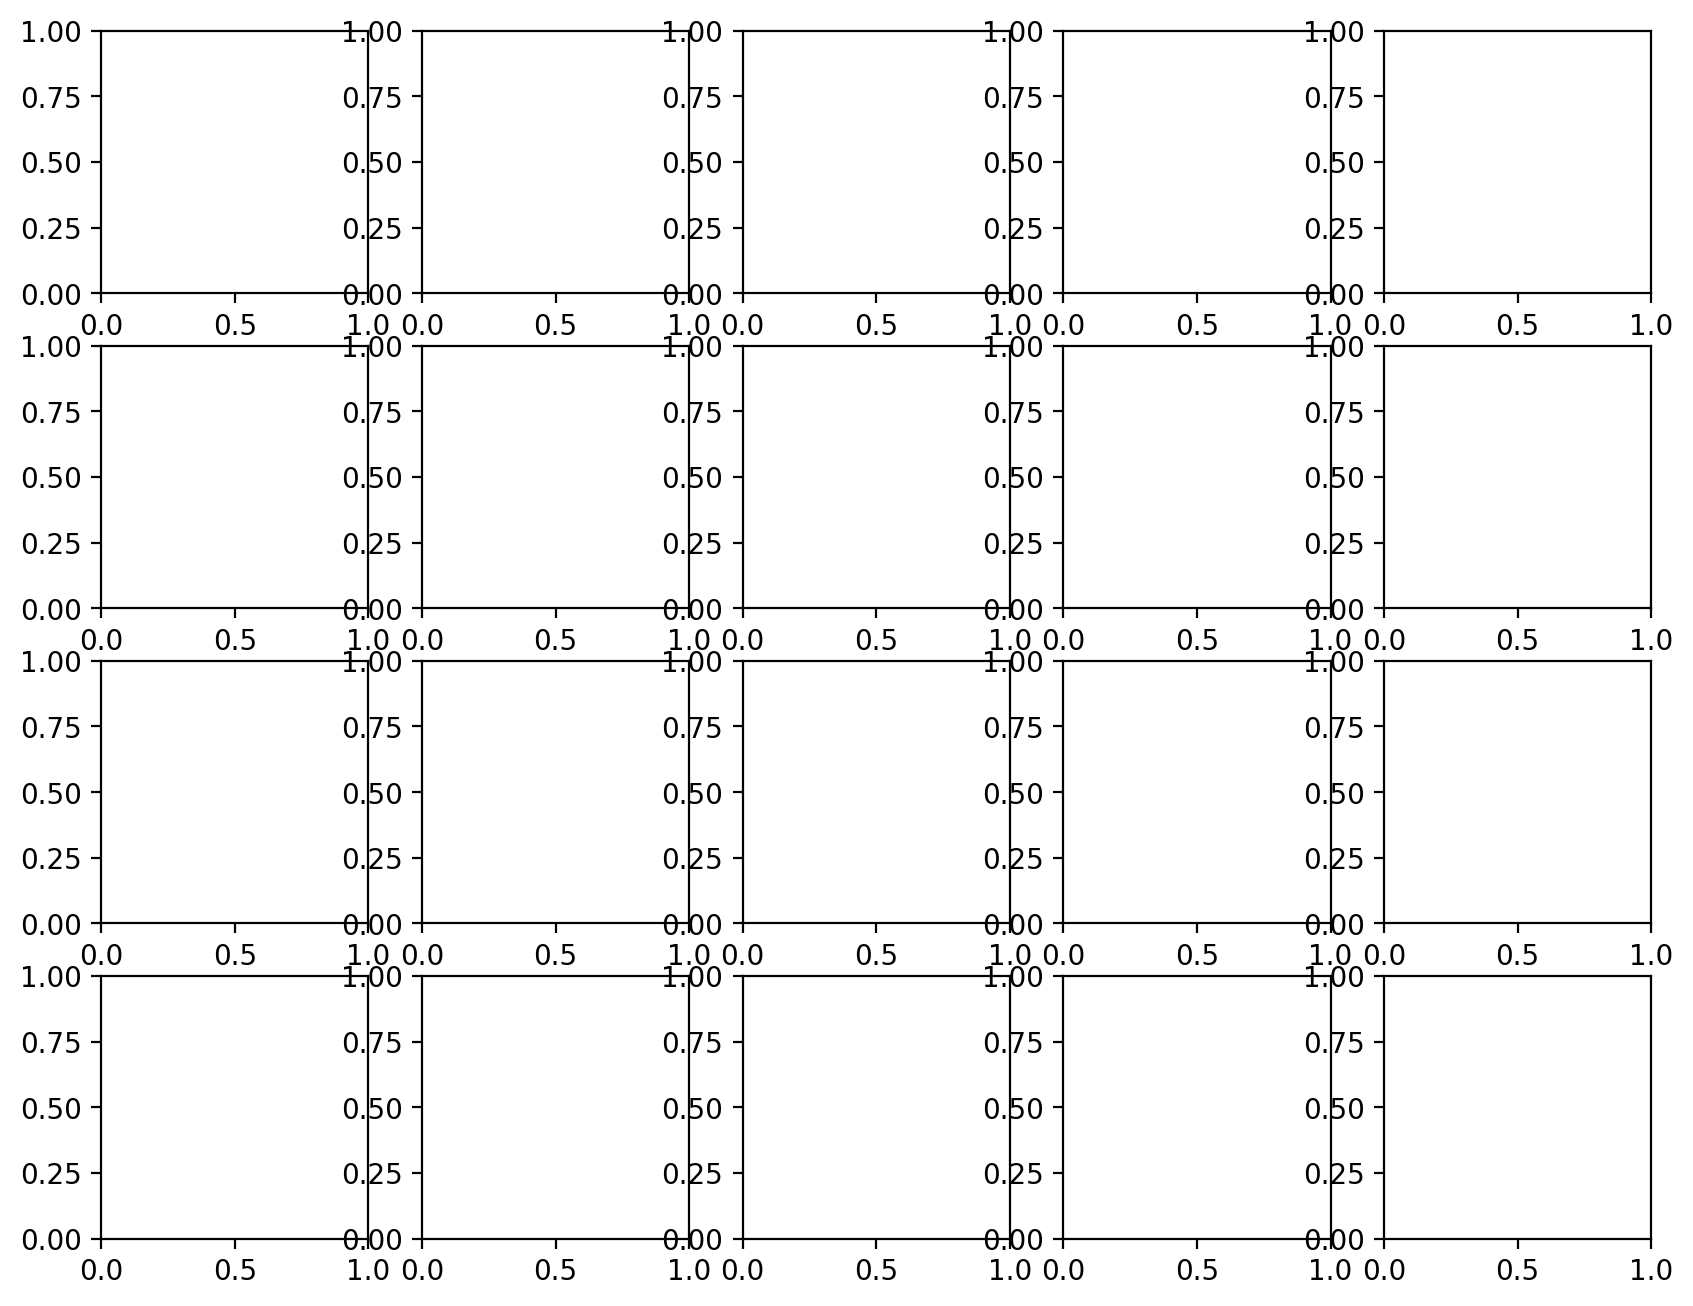

In [23]:
cnt = 0
fig, axs = plt.subplots(4, 5, dpi=200, figsize=(10, 8))
for idx, lang in enumerate(langs):
    ax = axs[idx // 5, idx % 5]
    ax.scatter(*zip(*projected_features[cnt:cnt + n_utt[idx]]), label=lang, s=0.5)
    ax.set_title(lang)
    ax.set_xticks([])
    ax.set_yticks([])
    cnt += n_utt[idx]
plt.savefig('pca.png')

In [63]:
de_start = n_utt[0]
de_end = n_utt[0] + n_utt[1]

fr_start = 0
fr_end = n_utt[0]

tgt_texts_de = tgt_texts_per_lang[1]
tgt_texts_fr = tgt_texts_per_lang[0]

In [64]:
min_ids = []
min_dists = []
for i in tqdm(range(de_start, de_end)):
    min_id = -1
    min_dist = 1e9
    for j in range(fr_start, fr_end):
        dist = ((projected_features[i] - projected_features[j]) ** 2).sum()
        if dist < min_dist:
            min_dist = dist
            min_id = j
    min_ids.append(min_id)
    min_dists.append(min_dist)

  0%|          | 0/13511 [00:00<?, ?it/s]

In [65]:
thres = sorted(min_dists)[int(len(min_dists) * 0.01)]
print(thres)

0.16542146


In [66]:
pairs = []
for i in range(de_start, de_end):
    if min_dists[i - de_start] <= thres:
        pairs.append((tgt_texts_de[i - de_start], tgt_texts_fr[min_ids[i - de_start] -fr_start]))

In [67]:
print(*pairs, sep='\n')

('Chill out, man!', 'Soot, guys!')
('It is located in the urban district Scharnhorst.', 'It is located in Vračar urban municipality.')
('The hospital is located at the northern edge of the quarter.', 'The warehouse is located at the north end of the line.')
('He studied German studies and history at the Eberhard Karls University of Tübingen.', 'Klaus Schmidt studied at the university of Erlangen and the university of Heidelberg.')
('That is true.', 'That, is true.')
('Are you kidding me?', 'Are you kidding?')
('Heh, how?', 'How?')
('What’s up?', 'What’s going on?')
('What is your name?', 'What is your name?')
('Could you get me some more salt and pepper, please?', 'Can we have a little more bread please?')
('He was married and has two children.', 'He is married and has eight children.')
('His scored first goal for the Turkish national team against England.', 'He received his first cape during a game against England.')
("There's no such thing!", 'There is none!')
('Thank you, likewise.'